In [2]:
import socket

print("Hostname: " + socket.gethostname())

Hostname: sx-el-121920


In [3]:
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

print("Torch version:", torch.__version__)

Torch version: 1.13.0a0+d0d6b1f


## Load datasets

In [4]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

# dataset parameters
DATASET_BATCH_SIZE = 128
DATASET_SHUFFLE = True

In [5]:
from torchvision import transforms

# initialize datasets
train_set = DatasetMNIST(root='./data',
                            env='train',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            transform= transforms.Compose([transforms.ToTensor()]))

val_set = DatasetMNIST(root='./data',
                            env='val',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_set = DatasetMNIST(root='./data',
                            env='test',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_set_fool = DatasetMNIST(root='./data',
                            env='test_fool',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            transform= transforms.Compose([transforms.ToTensor()]))

# create dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)

test_fool_loader = torch.utils.data.DataLoader(dataset=test_set_fool,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)


MNIST dataset already exists
MNIST dataset already exists
MNIST dataset already exists
MNIST dataset already exists


In [6]:
print(f"Number of training samples: {len(train_loader.dataset.data_label_tuples)}")
print(f"Number of validation samples: {len(val_loader.dataset.data_label_tuples)}")
print(f"Number of test samples: {len(test_loader.dataset.data_label_tuples)}")
print(f"Number of test fool samples: {len(test_fool_loader.dataset.data_label_tuples)}")

Number of training samples: 9425
Number of validation samples: 1888
Number of test samples: 1866
Number of test fool samples: 1866


## Set device (For number crunching)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Initialize CLIP

In [8]:
import clip

model, preprocess = clip.load("RN50")
model.cuda().eval()

mnist_template = 'a photo of the number: "{}".'
mnist_classes = ["5", "8"]

In [9]:
from utils.clip_utils import *

train_similarity, train_high_low = clip_mnist_similarity(clip, model, preprocess, mnist_classes, mnist_template, train_loader, "Training color")
val_similarity, val_high_low = clip_mnist_similarity(clip, model, preprocess, mnist_classes, mnist_template, val_loader, "Validation color")
test_similarity, test_high_low = clip_mnist_similarity(clip, model, preprocess, mnist_classes, mnist_template, test_loader, "Test color")

In [10]:
print(f"Accuracy train binary MNIST color 5/8: {clip_mnist_binary_accuracy(train_similarity, train_high_low)}%")
print(f"Accuracy validation binary MNIST color 5/8: {clip_mnist_binary_accuracy(val_similarity, val_high_low)}%")
print(f"Accuracy test binary MNIST color 5/8: {clip_mnist_binary_accuracy(test_similarity, test_high_low)}%")

Accuracy train binary MNIST color 5/8: 93.83%
Accuracy validation binary MNIST color 5/8: 93.75%
Accuracy test binary MNIST color 5/8: 93.24%


## New try

goal: having the follwing texts:  

a photo of the number: "5"  
a photo of the number: "8"  
a photo of a green number  
a photo of a red number

inputs:  
- list of numbers  
- list of colors  


outputs:  
one list with text descriptions

In [11]:
mnist_digits_template = 'a photo of the number: "{}".'
mnist_digits_classes = ["5", "8"]
mnist_color_template = 'a photo of a {} number.'
mnist_color_classes = ["red", "green"]

In [12]:
text_descriptions = [mnist_digits_template.format(template) for template in mnist_digits_classes]
text_descriptions.extend([mnist_color_template.format(template) for template in mnist_color_classes])

text_descriptions

['a photo of the number: "5".',
 'a photo of the number: "8".',
 'a photo of a red number.',
 'a photo of a green number.']

In [230]:
def text_mapping_5_8_generator(version=0):
    if version == 0:
        text_descriptions = ['a photo of the number: "5".',
                            'a photo of the number: "8".',
                            'a photo of a red number.',
                            'a photo of a green number',
                            'a photo of the red number: "5".',
                            'a photo of the green number: "5".',
                            'a photo of the red number: "8".',
                            'a photo of the green number: "8".']
        match_map = {4:5,
                     7:8}
    elif version == 1:        
        text_descriptions = ['a photo of the number: "5".',
                            'a photo of the number: "8".',
                            'a photo of a red number.',
                            'a photo of a green number']
        # reward correct number
        match_map = {0:5,
                     1:8}
        # reward correct color
        # match_map = {2:5,
        #              3:8}
    elif version == 2:
        text_descriptions = ['a photo of a red number.',
                            'a photo of a green number']
        match_map = {0:5,
                     1:8}
    elif version == 3:
        text_descriptions = ['a photo of the number: "5".',
                            'a photo of the number: "8".']
        match_map = {0:5,
                     1:8}
    else:
        raise Exception("Oops.. Unhandled case!")

    # set default values to 99
    for i in range(10):
        if (i not in match_map.keys()):
            match_map.setdefault(i, 99)
        
    return text_descriptions, match_map

def apply_matching_dict(input):
    """"
    Wrapper function to apply dictionary to all elements of a tensor instead of using a for loop.
    """
    return text_mapping[input]

func = np.vectorize(apply_matching_dict)
text_descriptions, text_mapping = text_mapping_5_8_generator(version=1)

In [231]:
def nr_of_corrects(predictions, ground_truth, matching_func):
    """
    Maps the predictions into the ground-truth space and returns the number of correct predictions.
    """
    return (matching_func(predictions.squeeze()) == ground_truth.squeeze().numpy()).sum()

def img_pil_to_numpy(img):
    """
    Convert PIL images to numpy images to be able to display them with plt.imshow(..)
    """
    return np.transpose(img.numpy(), (1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


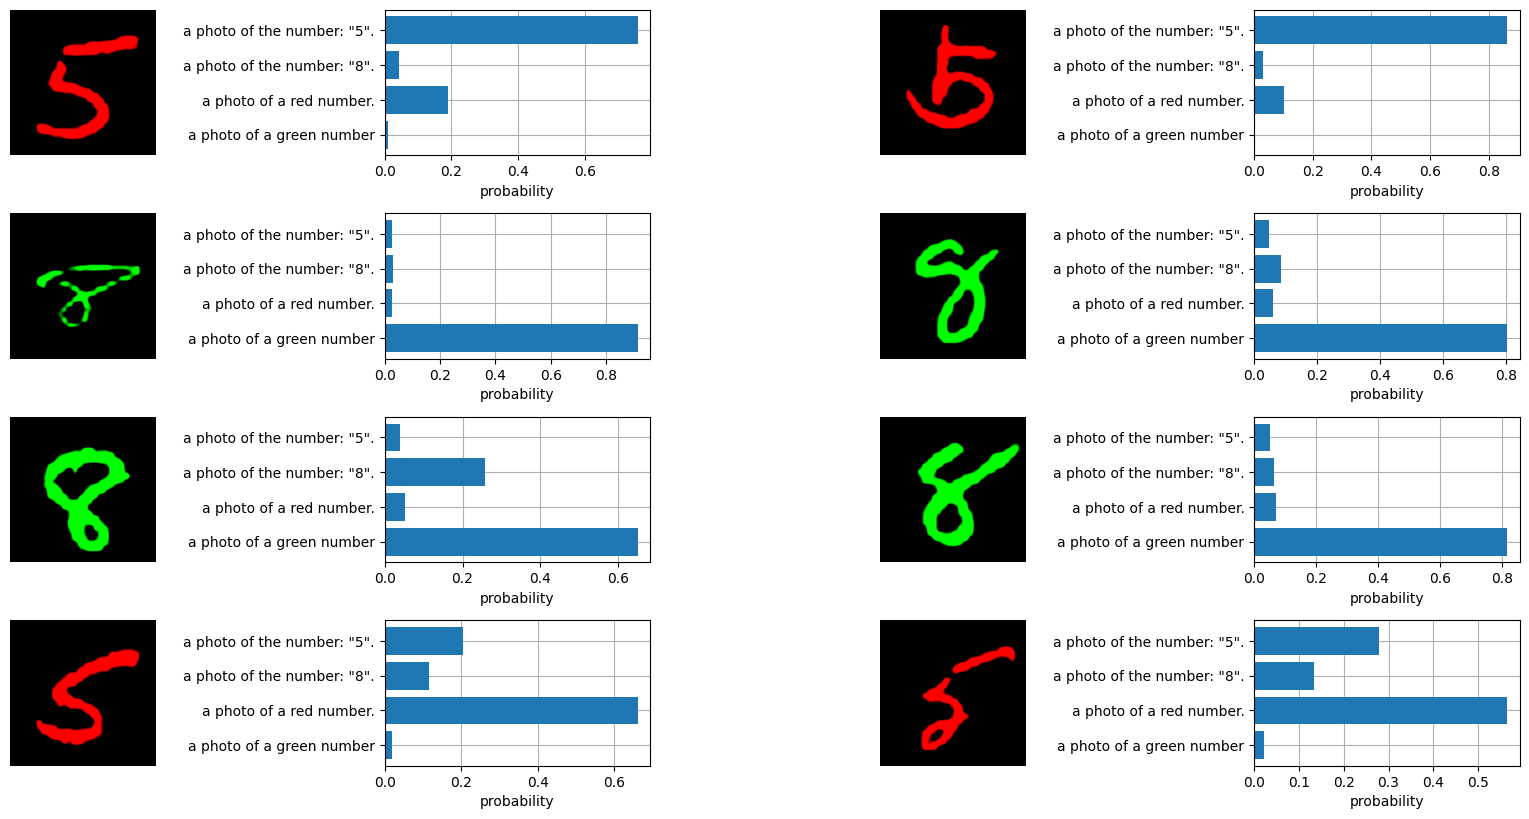

Accuracy train: 70.48%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


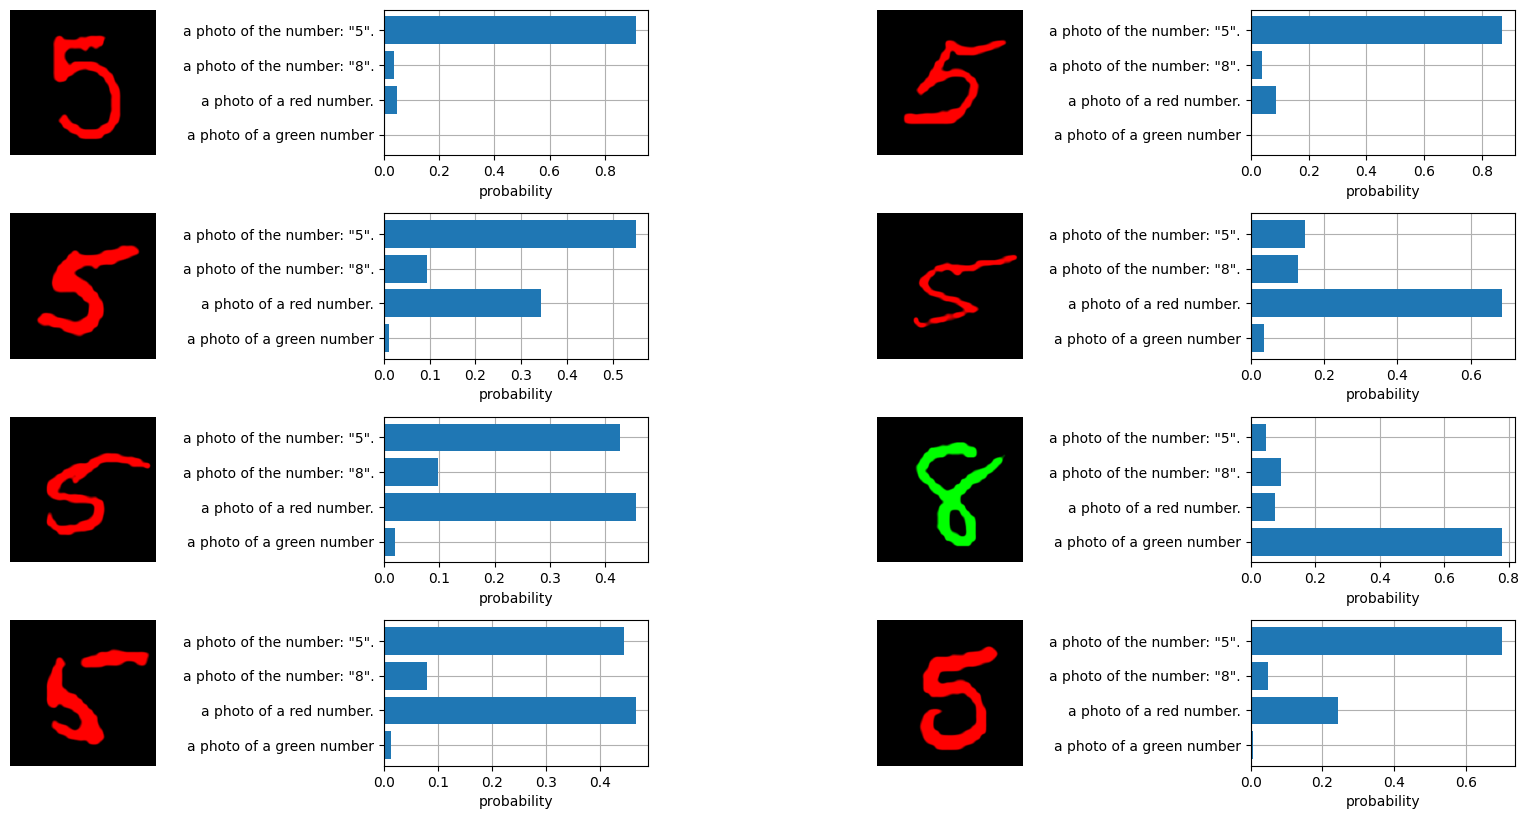

Accuracy validation: 70.49%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


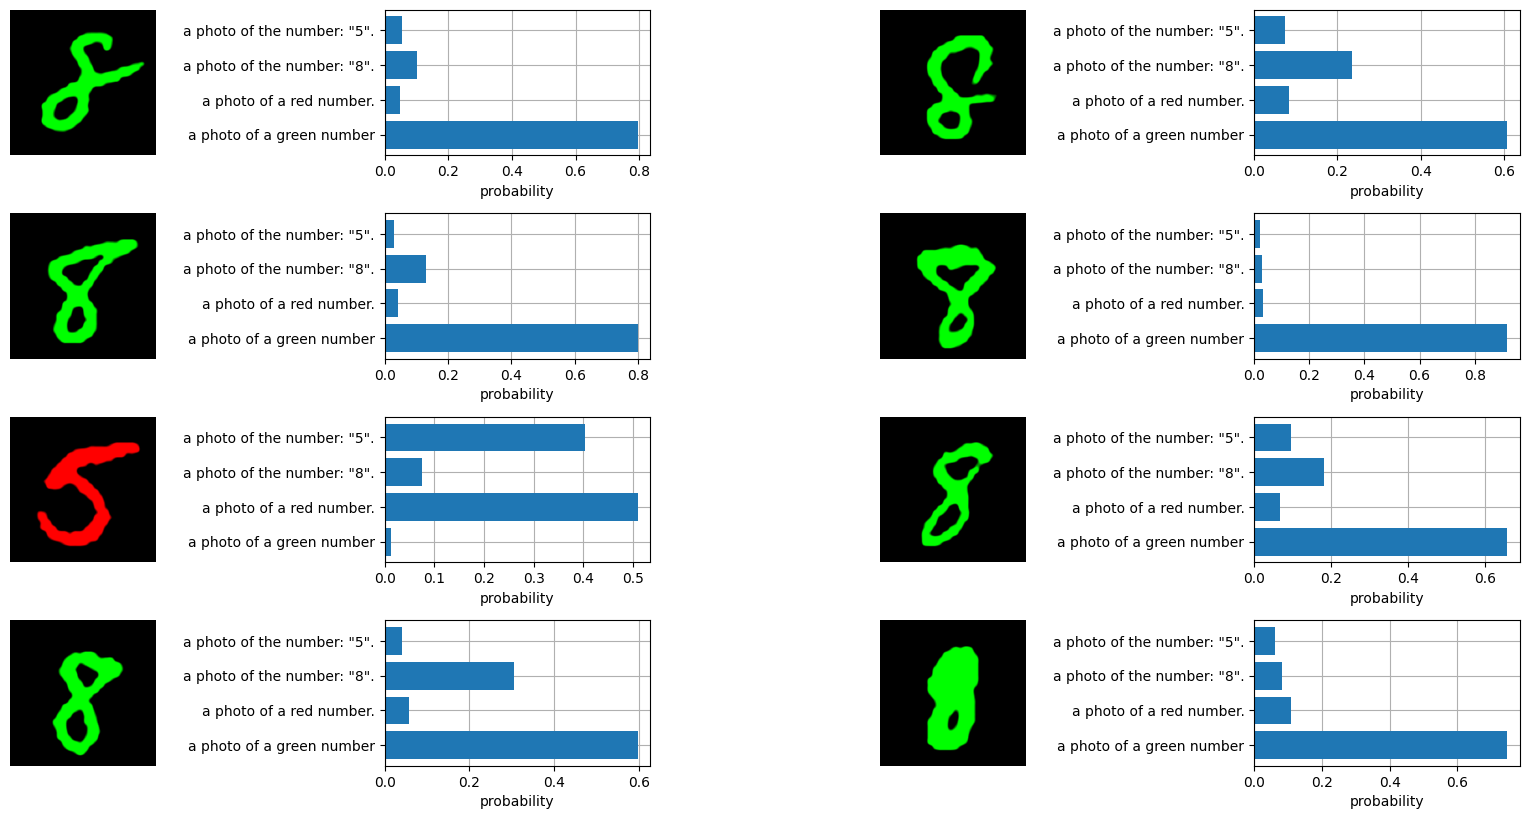

Accuracy test: 70.58%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


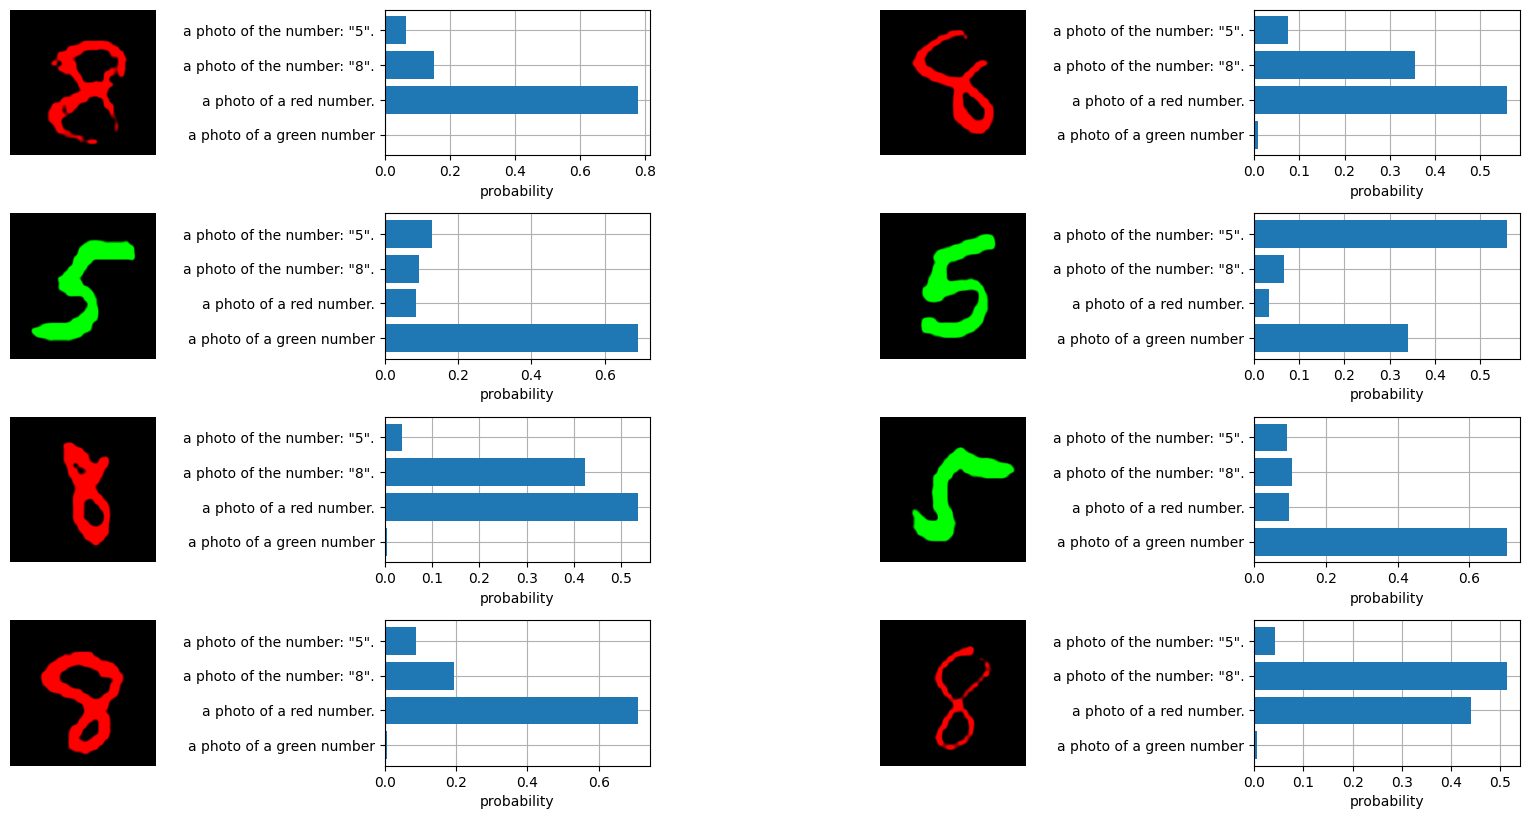

Accuracy test_fool: 61.83%


In [232]:
transform = transforms.ToPILImage()

# compute text features
text_tokens = clip.tokenize(text_descriptions).cuda()

with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    

datasources = {"train" : train_loader,
               "validation" : val_loader,
               "test" : test_loader,
               "test_fool" : test_fool_loader}
    
nr_of_imgs = 0
running_corrects = 0

for datasource in datasources:
    for images, ground_truth_label, _, _ in datasources[datasource]:
        # preprocess images
        images_new = []
        for img in images:
            images_new.append(preprocess(transform(img)))
            
        # transfer images to GPU
        images = torch.tensor(np.stack(images_new)).cuda()
        
        # compute image features
        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu()
        
        nr_of_imgs += ground_truth_label.shape[0]
        running_corrects += nr_of_corrects(text_probs.argmax(axis=1), ground_truth_label.flatten(), func)
        
    NR_OF_IMAGES = 8
    plt.figure(figsize=(16, 16))

    # warning of clippig input data to valid range comes from the std-scaler preprocessor (Fine for display purposes!)
    for i, image in enumerate(images.cpu()):
        if i<NR_OF_IMAGES:
            plt.subplot(NR_OF_IMAGES, 4, 2 * i + 1)
            plt.imshow(img_pil_to_numpy(image))
            plt.axis("off")
            
            plt.subplot(NR_OF_IMAGES, 4, 2 * i + 2)
            y = np.arange(text_probs.shape[1])
            plt.grid()
            plt.barh(y, text_probs[i].detach().numpy())
            plt.gca().invert_yaxis()
            plt.gca().set_axisbelow(True)
            plt.yticks(y, text_descriptions)
            plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.tight_layout()
    plt.show()

    print(f"Accuracy {datasource}: {np.round(100.0 * running_corrects / nr_of_imgs, 2)}%")
